In [2]:
!pip install astroquery -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 41.2 MB/s eta 0:00:00


In [3]:
from astroquery.alma import Alma
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from matplotlib import cm

In [11]:
Alma.help()


Most common ALMA query keywords are listed below. These keywords are part of the ALMA ObsCore model, an IVOA standard for metadata representation (3rd column). They were also present in original ALMA Web form and, for backwards compatibility can be accessed with their old names (2nd column).
More elaborate queries on the ObsCore model are possible with `query_sia` or `query_tap` methods
  Description                       Original ALMA keyword               ObsCore keyword                    
-------------------------------------------------------------------------------------------------------

Position
  Source name (astropy Resolver)    source_name_resolver                SkyCoord.from_name                 
  Source name (ALMA)                source_name_alma                    target_name                        
  RA Dec (Sexagesimal)              ra_dec                              s_ra, s_dec                        
  Galactic (Degrees)                galactic                   

In [9]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/Shareddrives/Follette Lab/Summer 2024/Projects/Exoplanets/Circumstellar Disk Tool (Bibi)/TOOL/Final/DATA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Get the disks from my spreadsheet into a list! (Mostly Alex's code)
from google.colab import auth
import gspread
from google.auth import default
auth.authenticate_user()

creds, _ = default()
gc = gspread.authorize(creds)

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Tos2gWukEMvjOrZ0ai975ecqD1BH-rYwlr2dJd5__oM/edit#gid=0')
sheet = wb.worksheet('Disk Information')
data = sheet.get_all_values()
df = pd.DataFrame(data)

# Arrange Pandas dataframe
df.columns = df.iloc[0]
df = df.drop(df.index[0])
# Covert each column to a list
disks = df['SIMBAD Name'].values.tolist()
# Trim empty values
while '' in disks: disks.remove('')
# Add the column to the dictionary of data

In [5]:
disks

['HD 135344B',
 'HD 100453',
 'TW Hya',
 'RXJ 1615.3-3255',
 'HD 169142',
 'EM* SR 21 A',
 'HD 34700',
 'EX Lup',
 'HD 143006',
 'HD 139614',
 'GG Tau',
 'RXJ1604.3-2130',
 'HD 142527',
 'IM Lup',
 'MY Lup',
 'HD 34282',
 'DO Tau',
 '2MASS_J16154416-1921171',
 'GW Ori']

weighted sum method: using this to consider both spatial resolution and continuum sensitivity equally. finds the one 'best' observation/best compromise between the two parameters

In [12]:
def query_best_observation(target_object):
    """
    Query the ALMA archive for a specific target object, filter all the observations to band list 7,
    and return the meta info for the observation of that object with the highest spatial resolution
    and the highest continuum sensitivity. This function only deals with 'image' (continuum) data
    and does not effectively handle 'line' data yet.

    Parameters:
    target_object (str) - the object to query

    Returns:
    A dictionary containing the following keys:
    - 'Target': The name of the target object
    - 'Max Resolution': The maximum spatial resolution among the observations
    - 'Max Continuum Sensitivity': The maximum continuum sensitivity among the observations
    - 'Data Download URL': The URL where the data for the best observation can be downloaded
    - 'Downloaded Files': A list of the downloaded files
    - 'Project Code': The project code of the best observation
    - 'Data Product Type': The type of data product of the best observation
    - 'Band List': The band list of the best observation
    - 'Integration Time': The integration time of the best observation
    """
    # Query Simbad for the target object
    customSimbad = Simbad()
    result_table = customSimbad.query_object(target_object)

    # Grab object coordinates from the Simbad query results
    ra = result_table['RA'][0]  # Right Ascension
    dec = result_table['DEC'][0]  # Declination

    # Define the coordinates for the target object using SkyCoord
    coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))

    # Access ALMA archive to search for data related to the target object
    radius = 0.001 * u.deg  # Define search radius around the coordinates

    # Query the ALMA archive for data within the specified coordinates
    result = Alma.query_region(coords, radius=radius)

    # Create a DataFrame from the query results
    df = result.to_pandas()

    # Filter rows for band 7 and 'image' (continuum) data
    #df = df[(df['band_list'] == '7') & (df['dataproduct_type'] == 'image')]
    df = df[(df['band_list'] in ('6', '7')) & (df['dataproduct_type'] == 'image') & (df['pol_states'] == '/XX/YY/')]

    # Normalize the two parameters (spatial resolution and continuum sensitivity columns); divide by max to put on same scale
    df['spatial_resolution_normalized'] = df['spatial_resolution'] / df['spatial_resolution'].max()
    df['cont_sensitivity_bandwidth_normalized'] = df['cont_sensitivity_bandwidth'] / df['cont_sensitivity_bandwidth'].max()

    # Calculate the weighted sum of the normalized columns (multiply each column by its weight, equal weight for both (could adjust), and add together)
    df['weighted_sum'] = 0.5 * df['spatial_resolution_normalized'] + 0.5 * df['cont_sensitivity_bandwidth_normalized']

    # Find the row with the highest weighted sum (best balance of spatial resolution and continuum senstivity)
    try:
        best_row = df.loc[df['weighted_sum'].idxmax()]
    except:
        print(f"No observations found for {target_object}. Mi hermano en Cristo")
        return None

    # Get the data info for the best observation
    uid_url_table = Alma.get_data_info(best_row['member_ous_uid'], expand_tarfiles=True)

    # Filter for tar files
    #tar_urls = [url for url in uid_url_table['access_url'] if '.tar' in url]

    # Filter for fits files
    fits_urls = [url for url in uid_url_table['access_url'] if '.fits' in url]

    # Download the tar files
    filelist = Alma.download_files(fits_urls, savedir='continuum/ALMA/')

    #print(df)

    # Return meta-information, download URL, and filelist for the observation with the best quality
    return {
        'Target': target_object,
        'Max Resolution': best_row['spatial_resolution'],
        'Max Continuum Sensitivity (mJy/beam)': best_row['cont_sensitivity_bandwidth'],
        'Data Download URL': best_row['access_url'],
        #'Downloaded Files': filelist,
        'Project Code': best_row['proposal_id'],
        'Data Product Type': best_row['dataproduct_type'],
        'Band List': best_row['band_list'],
        'Integration Time (s)': best_row['t_exptime']
    }

In [13]:
# Now querying the best observation for a sample of disks

for disk in disks:
    best_observation = query_best_observation(disk)
    print(f"Best observation for {disk}:")
    print(best_observation)
    print("\n")


KeyboardInterrupt: 

In [ ]:
def gather_all_observations_meta(disks):
    all_meta_info = []

    for disk in disks:
        # Query ALMA archive for data related to the target object
        result_table = Simbad.query_object(disk)
        ra = result_table['RA'][0]  # Right Ascension
        dec = result_table['DEC'][0]  # Declination
        coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
        radius = 0.001 * u.deg  # Define search radius around the coordinates
        result = Alma.query_region(coords, radius=radius)
        df = result.to_pandas()

        # Filter the DataFrame to include only observations in band list 7 and of data type 'image' (continuum)
        #df = df[(df['band_list'] == '7') & (df['dataproduct_type'] == 'image')]
        #df = df[(df['band_list'] == '7') & (df['dataproduct_type'] == 'image') & (df['pol_states'] == '/XX/YY/')]
        df = df[((df['band_list'] == '7') | (df['band_list'] == '6')) & (df['dataproduct_type'] == 'image') & (df['pol_states'] == '/XX/YY/')]


        if not df.empty:
            # Extract meta-info for each observation and add it to the list
            for idx, observation in df.iterrows():
                meta_info = {
                    'Disk': disk,
                    'Spatial Resolution': observation['spatial_resolution'],
                    'Continuum Sensitivity (mJy/beam)': observation['cont_sensitivity_bandwidth'],
                    'Data Download URL': observation['access_url'],
                    'Project Code': observation['proposal_id'],
                    'Data Product Type': observation['dataproduct_type'],
                    'Band List': observation['band_list'],
                    'Integration Time (s)': observation['t_exptime']
                }
                all_meta_info.append(meta_info)

    # Return DataFrame containing meta-info for all observations
    return pd.DataFrame(all_meta_info)

# List of disks
#disks = ["HL Tau", "Elia 2-24", "AS 209", "V1094 Sco", "V1247 Ori", "Sz 98", "RXJ 1615.3-3255", "AA Tau", "TW Hya", "HD 100546", "HD 169142", "HD 135344B", "HD 100453", "HD 163296", "HD 97048", "IM Lup", "GM Aur", "MWC 480"]
disks = ["AS 209", "RXJ 1615.3-3255", "TW Hya", "HD 100546", "HD 169142", "HD 135344B", "HD 163296", "HD 97048"]

# Gather all observations and meta-info for each disk
all_observations_meta = gather_all_observations_meta(disks)

# Display the DataFrame containing meta-info for all observations
pd.set_option('display.max_rows', None)
all_observations_meta


,Disk,Spatial Resolution,Continuum Sensitivity (mJy/beam),Data Download URL,Project Code,Data Product Type,Band List,Integration Time (s)
0,AS 209,0.253611,0.024851,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,756.000
1,AS 209,0.253611,0.024851,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,756.000
2,AS 209,0.253611,0.024851,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,756.000
3,AS 209,0.033484,0.015991,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,4136.600
4,AS 209,0.033484,0.015991,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,4136.600
5,AS 209,0.033484,0.015991,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,4136.600
6,AS 209,0.172207,0.041465,https://almascience.org/datalink/sync?ID=uid:/...,2015.1.00486.S,image,6,4717.358
7,RXJ 1615.3-3255,0.062596,0.034075,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.01286.S,image,7,1759.968
8,RXJ 1615.3-3255,0.062596,0.034075,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.01286.S,image,7,1759.968
9,RXJ 1615.3-3255,0.293760,0.085493,https://almascience.org/datalink/sync?ID=uid:/...,2012.1.00870.S,image,7,1753.918


<ipython-input-5-dd53605aaaf2>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20b', num_colors)


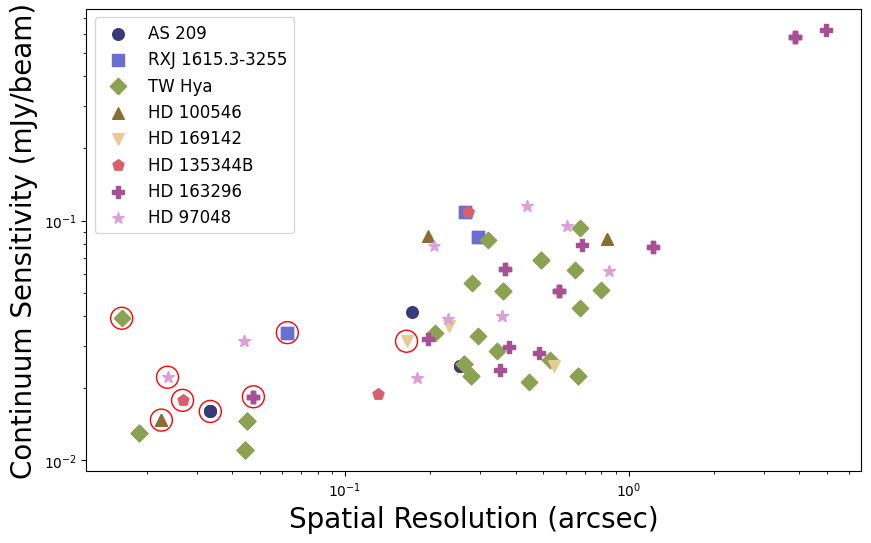

In [ ]:
# Query ALMA for all observations in band list 7 of 'image' type for each disk
disks = ["AS 209", "RXJ 1615.3-3255", "TW Hya", "HD 100546", "HD 169142", "HD 135344B", "HD 163296", "HD 97048"]

def gather_all_observations(disks):
    all_observations = []
    for disk in disks:
        # Query ALMA archive for data related to the target object
        result_table = Simbad.query_object(disk)
        ra = result_table['RA'][0]  # Right Ascension
        dec = result_table['DEC'][0]  # Declination
        coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
        radius = 0.001 * u.deg  # Define search radius around the coordinates
        result = Alma.query_region(coords, radius=radius)
        df = result.to_pandas()

        # Filter df to include only observations in band list 7 and of data type 'image' (continuum)
        #df = df[(df['band_list'] == '7') & (df['dataproduct_type'] == 'image')]
        #df = df[(df['band_list'] == '7') & (df['dataproduct_type'] == 'image') & (df['pol_states'] == '/XX/YY/')]
        df = df[((df['band_list'] == '7') | (df['band_list'] == '6')) & (df['dataproduct_type'] == 'image') & (df['pol_states'] == '/XX/YY/')]


        # Append observations to the list
        all_observations.append(df)
    return all_observations

def plot_all_observations_highlighted(all_observations):
    plt.figure(figsize=(10, 6))
    num_colors = len(all_observations)
    cmap = cm.get_cmap('tab20b', num_colors)
    markers = ['o', 's', 'D', '^', 'v', 'p', 'P', '*', 'X', 'd', 'H', '+']

    # Plot observations for each disk
    for i, observations in enumerate(all_observations):
        # Use modulo to cycle through markers and colors
        marker = markers[i % len(markers)]
        color = cmap(i % cmap.N)

        spatial_resolution = observations['spatial_resolution']
        continuum_sensitivity = observations['cont_sensitivity_bandwidth']
        plt.scatter(spatial_resolution, continuum_sensitivity, color=color, marker=marker, s=70, label=disks[i])

        # Mark the leftmost ('best') observation (min spatial resolution) with a red circle
        if not observations.empty:
            min_spatial_resolution_idx = observations['spatial_resolution'].idxmin()
            min_spatial_resolution_observation = observations.loc[min_spatial_resolution_idx]
            plt.scatter(min_spatial_resolution_observation['spatial_resolution'],
                        min_spatial_resolution_observation['cont_sensitivity_bandwidth'],
                        color='red', marker='o', s=250, facecolors='none')

    plt.ylabel('Continuum Sensitivity (mJy/beam)', fontsize=20)
    plt.xlabel('Spatial Resolution (arcsec)', fontsize=20)
    plt.legend(loc='upper left', fontsize=12)
    plt.yscale('log')
    plt.xscale('log')
    plt.savefig('observations_plot.png', dpi=300)
    plt.show()


# Gather all observations for each disk
all_observations = gather_all_observations(disks)

# Plot
plot_all_observations_highlighted(all_observations)


In [ ]:
# Function to gather all observations AND meta-info for each disk
def gather_all_observations_meta(disks):
    all_observations_meta = []

    for disk in disks:
        # Query ALMA archive for data related to the target object
        result_table = Simbad.query_object(disk)
        ra = result_table['RA'][0]  # Right Ascension
        dec = result_table['DEC'][0]  # Declination
        coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
        radius = 0.001 * u.deg  # Define search radius around the coordinates
        result = Alma.query_region(coords, radius=radius)
        df = result.to_pandas()

        # Filter the DataFrame to include only observations in band list 7 and of data type 'image' (continuum)
        df = df[((df['band_list'] == '7') | (df['band_list'] == '6')) & (df['dataproduct_type'] == 'image') & (df['pol_states'] == '/XX/YY/')]


        if not df.empty:
            # Find the observation with the lowest spatial resolution
            min_spatial_resolution_idx = df['spatial_resolution'].idxmin()
            min_spatial_resolution_observation = df.loc[min_spatial_resolution_idx]

            # Exract meta-info for the leftmost observation
            leftmost_observation_meta = {
                'Target': disk,
                'Spatial Resolution': min_spatial_resolution_observation['spatial_resolution'],
                'Continuum Sensitivity (mJy/beam)': min_spatial_resolution_observation['cont_sensitivity_bandwidth'],
                'Data Download URL': min_spatial_resolution_observation['access_url'],
                'Project Code': min_spatial_resolution_observation['proposal_id'],
                'Data Product Type': min_spatial_resolution_observation['dataproduct_type'],
                'Band List': min_spatial_resolution_observation['band_list'],
                'Integration Time (s)': min_spatial_resolution_observation['t_exptime'],
                'Polarisation type (Single, Dual, Full)': min_spatial_resolution_observation['pol_states']
            }
            all_observations_meta.append(leftmost_observation_meta)

    return pd.DataFrame(all_observations_meta)

# List of disks
#disks = ["HL Tau", "Elia 2-24", "AS 209", "V1094 Sco", "V1247 Ori", "Sz 98", "RXJ 1615.3-3255", "AA Tau", "TW Hya", "HD 100546", "HD 169142", "HD 135344B", "HD 100453", "HD 163296", "HD 97048", "IM Lup", "GM Aur", "MWC 480"]
disks = ["AS 209", "RXJ 1615.3-3255", "TW Hya", "HD 100546", "HD 169142", "HD 135344B", "HD 163296", "HD 97048", "IM Lup"]

# Gather all observations and meta-info for each disk
all_observations_meta = gather_all_observations_meta(disks)
all_observations_meta


,Target,Spatial Resolution,Continuum Sensitivity (mJy/beam),Data Download URL,Project Code,Data Product Type,Band List,Integration Time (s),"Polarisation type (Single, Dual, Full)"
0,AS 209,0.033484,0.015991,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,4136.600,/XX/YY/
1,RXJ 1615.3-3255,0.062596,0.034075,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.01286.S,image,7,1759.968,/XX/YY/
2,TW Hya,0.016304,0.039125,https://almascience.org/datalink/sync?ID=uid:/...,2015.1.00686.S,image,7,7909.899,/XX/YY/
3,HD 100546,0.022502,0.014714,https://almascience.org/datalink/sync?ID=uid:/...,2018.1.01309.S,image,6,17741.877,/XX/YY/
4,HD 169142,0.164705,0.031376,https://almascience.org/datalink/sync?ID=uid:/...,2015.1.01301.S,image,6,1753.920,/XX/YY/
5,HD 135344B,0.026726,0.017791,https://almascience.org/datalink/sync?ID=uid:/...,2018.1.01066.S,image,6,7813.583,/XX/YY/
6,HD 163296,0.047504,0.018407,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,3229.631,/XX/YY/
7,HD 97048,0.023650,0.022208,https://almascience.org/datalink/sync?ID=uid:/...,2019.1.01091.S,image,6,8817.797,/XX/YY/
8,IM Lup,0.023010,0.014771,https://almascience.org/datalink/sync?ID=uid:/...,2016.1.00484.L,image,6,4170.492,/XX/YY/
